# Kevin Liu CMSC320 Project 2

The following code is the imports and our initial reading and set up to read into the SQLite database provided for the project.

In [106]:
import sqlite3
import pandas
import matplotlib.pyplot as plt
import numpy


sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

# PROBLEM 1 - DATA WRANGLING
**Explanation of Code**

At this point, we have to figure out our query to create the database we will use for the assignment. Throughout the project I have identified that we will need to utilize a measurement of time, name of the team, the franchise and team IDs, the Win Rate of the team, and the Salary Cap of the team.

Therefore we have selected those elements. However, it is important to choose where we obtain these from. For the measurement of time, I have decided to use the Salaries yearID key. This is because we want to conduct operations on the salary cap by year per each team, and it would be a lot convenient to have the salary already available for the total year.

We will also utilize a Inner Join in order to make sure all salary data is present, but also all team data is also present. We originally chose a left join, but this gave us one extra column (New York Mets in 2014). However, this row was the only row with data not filled in. Therefore, we can deal with rows with missing data by simply utilizing an inner join to remove this row. I will also perform a check at the end of the inner join to make sure there are no rows with missing data in the table. This is to make sure our graphs work without incident.

We also have conveniently relabeled the the Columns upon their creation to make more sense. The gist of the selection obtains a salary by year, then merges them together by team and year, giving every teams salary for that year. It does this for every year and every team. It then uses the match between team id and year id to also obtain the teams wins, games, names, franchise and team id, and can use these columns to calculate the salary sums and win rates.



In [107]:
salary_query = """SELECT Salaries.yearID AS "Year", name as "Name", Teams.franchID AS "Franchise ID", Salaries.teamID AS "Team ID", Teams.W, Teams.G,
                    ROUND((( CAST(Teams.W AS FLOAT) / CAST(Teams.G AS FLOAT)) * 100.0),1) AS "Win Rate",  SUM(Salaries.salary) AS "Salary Cap"
                FROM Salaries
                    INNER JOIN 
                        (
                            SELECT Teams.franchID, Teams.teamID, Teams.name, Teams.yearID, Teams.G, Teams.W 
                            FROM Teams
                        ) Teams
                    ON Salaries.yearID == Teams.yearID AND Salaries.teamID == Teams.teamID
                WHERE Salaries.yearID >= 1985
                GROUP BY Salaries.yearID, Teams.franchID
                ORDER BY Salaries.yearID, Teams.franchID"""

#So that we can actually use this data
team_salaries = pandas.read_sql(salary_query, conn)
team_salaries.head()

,Year,Name,Franchise ID,Team ID,W,G,Win Rate,Salary Cap
0,1985,California Angels,ANA,CAL,90,162,55.6,14427894.0
1,1985,Atlanta Braves,ATL,ATL,66,162,40.7,14807000.0
2,1985,Baltimore Orioles,BAL,BAL,83,161,51.6,11560712.0
3,1985,Boston Red Sox,BOS,BOS,81,163,49.7,10897560.0
4,1985,Chicago Cubs,CHC,CHN,77,162,47.5,12702917.0


In [108]:
# print which rows have the missing data, making sure we don't have any
print(team_salaries.loc[team_salaries["W"].isnull()])

Empty DataFrame
Columns: [Year, Name, Franchise ID, Team ID, W, G, Win Rate, Salary Cap]
Index: []


So since we utilized the inner join, we don't have any missing rows that we would have had with a left join. Therefore, we have our data table ready for our graphs!

# Part 2 Exploratory Data Analysis

## Problem 2
Explanation:

The first step is to create a graph that depicts each teams cap spending per year from 1990-2014. There are a couple of problems with this. The first is that our current data set can easily be transformed into a graph by itself. Additionally, the data itself is lacking, at no fault of ours or the person who created the database. Some teams were did not exist until after 1990, and some teams ceased to exist before reaching 2014. This lead to incomplete data that we have to take care of.

Therefore, this is what we ended up doing:
1) First I have to clean up the data. Therefore, I create a series of a subset of the data, the data I want. In this series, the keys is the year for each team, and the value is the Salary for that team for that year. I do this by using a sum and groupby function.

2) We will ultimately have to list through each team. Instead of manually writing in each team, we find the unique keys of Team ID and store it.

3) With the set up and data wrangling accomplished, we can go ahead and go through these new datasets and plot our graph. First and foremost, we iterate through each team, in order to get all teams data onto the plot. Here is an important part that tripped me up for a while, each team will not consistently have data for the 1990-2014 seasons, whether they begin halfway into it, end before 2014, or a variety of other factors. Therefore, in order to avoid errors, we have to specifically identify the years that those teams have data for. Therefore, we can use the indices of the series we just made in step 1 in order to match it with the team we are currently iterating through, and obtain the salary without issue. We do this.

4) Now we have to edit the labels. We have filtered the data that is plotted to make sure that it is between 1990-2014 so we don't have to worry about changing the axis to reflect it.

5) I also have a small if statement to color the Oakland Athletics data point red, just to see where they stand, especially in the years 2000-2005. It is just for personal interest and note.

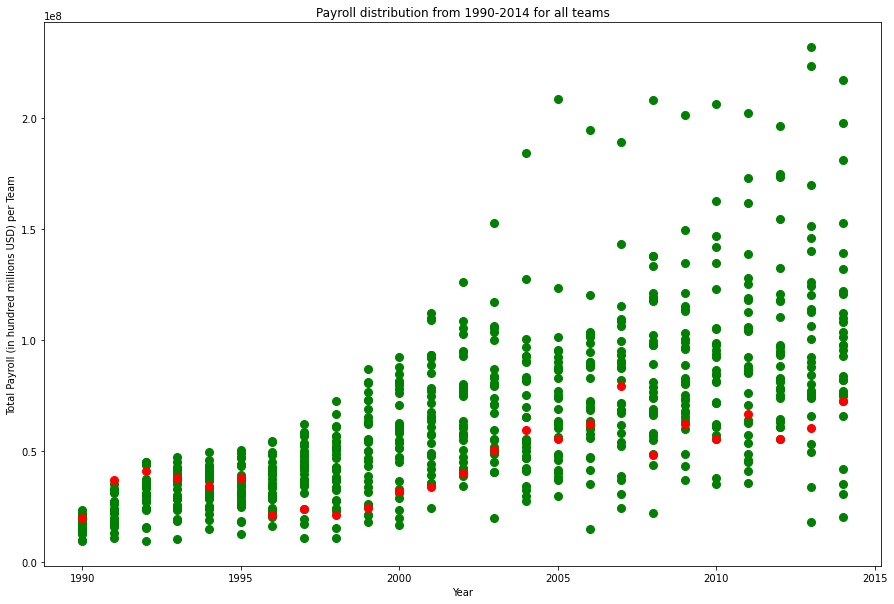

In [109]:
#Step 1, cleaning up the data by creating a series with the years of each team as the key, and that year's salary cap for the value
sumOfSalaries = team_salaries.groupby(by=["Team ID", "Year"])["Salary Cap"].sum()

#sizing
plt.rcParams["figure.figsize"] = (15, 10)

# list of all teams
teams = team_salaries["Team ID"].unique()

for t in teams:
    for i in sumOfSalaries[t].index:
        if i >= 1990 and i <= 2014:
            if t == "OAK":
                #This highglights the Oakland Athletic's spending for easier analysis, and also puts it on top to see easier
                plt.plot(i,sumOfSalaries[t,i], color = "red", marker = "o", markersize = 8, label = t, zorder = 2)
            else:
                plt.plot(i,sumOfSalaries[t,i], color = "green", marker = "o", markersize = 8, label = t, zorder = 1)            
#label and axis work
plt.title("Payroll distribution from 1990-2014 for all teams")
plt.ylabel("Total Payroll (in hundred millions USD) per Team")
plt.xlabel("Year")
plt.show()

## Question 1

1) The first thing I noticed was that the spread/variance increased rapidly. It actually begins around 1997, which is the last year that the salary spending is within a tight spread. We begin to see a rapid spread, in which some teams are still paying the "traditional" amount per year, whereas some other teams are beginning to up their spending. This variance in spending and difference of spending between the top and bottom teams continues to increase with time.

2) The second thing I noticed is that the mean and median spending per year is increasing with time - teams are spending more, especially a specific few of them.

3) The third thing I noticed is based around the Oakland Athletic's and what we are trying to answer in the biggest sense (The Question). It seems that from this initial graph, we can see that the Oakland Athletic's spent below the mean in years 2000-2005.

## Problem 3

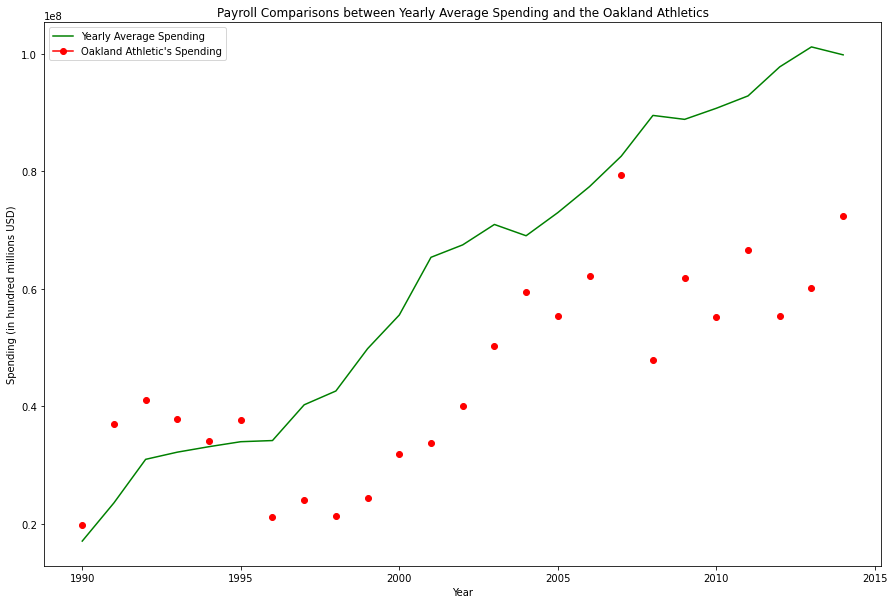

In [110]:
#sumOfSalaries = team_salaries.groupby(by=["Team ID", "Year"])["Salary Cap"].sum()
#teams = team_salaries["Team ID"].unique()

#To plot the yearly average salary of all teams
yearlySalary = team_salaries.groupby(by = ["Year"])["Salary Cap"].mean()
x = yearlySalary[5::]

plt.plot(range(1990, 2015), x, color = "green")

#To plot the yearly salary of Oakland Athletics
for i in sumOfSalaries["OAK"].index:
    if i >= 1990 and i <= 2014:
        #This highglights the Oakland Athletic's spending for easier analysis, and also puts it on top to see easier
        plt.plot(i,sumOfSalaries["OAK",i], color = "Red", marker = "o", markersize = 6, zorder = 2)

#This edits the graph axis
plt.xticks(range(1990, 2016, 5))
plt.legend(["Yearly Average Spending", "Oakland Athletic's Spending"])
plt.title("Payroll Comparisons between Yearly Average Spending and the Oakland Athletics")
plt.ylabel("Spending (in hundred millions USD)")
plt.xlabel("Year")
plt.show()


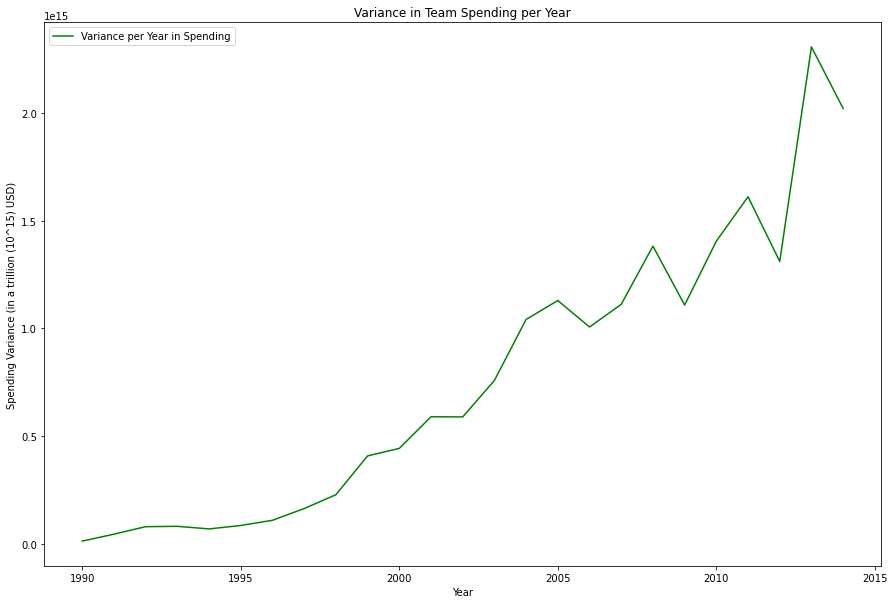

In [111]:
# attempt to figure out variance. we need to iterate through all values within that year, then we have to subtract it from the mean, 
#div by total, sum
varianceList = {};
salaries = team_salaries.groupby(by = ["Year","Team ID"])["Salary Cap"].sum()

#calculating variance
for i in range(1990, 2015):
    variance = 0
    count = salaries[i].count()
    for x in salaries[i]:
        variance += (pow((x - yearlySalary[i]),2)/count)
    varianceList.update({i:variance})
#end

#plotting variance
plt.plot(varianceList.keys(), varianceList.values(), color = "green", label = "Variance per Year in Spending")

#Plot settings
plt.xticks(range(1990, 2016,5))
plt.title("Variance in Team Spending per Year")
plt.ylabel("Spending Variance (in a trillion (10^15) USD)")
plt.xlabel("Year")
plt.legend(loc = "upper left")
plt.show()

These 2 plots support all 3 of our above evaluations. The first plot compares the yearly average spending within the MLB and then also plots the spending of the Oakland Athletics each year. We can notice that spending has been increasing rapidly and linearly, supporting claim number 2. Then, we also note that for years 2000-2005, we can visible see that the Oakland Athletic's have been spending less money than their yearly averages, supporting claim number 3.

Additionally, our second plot calculates and plots the spending variance of the MLB teams per year. It shows a rapid increase in variance, especially around the years of 1998, supporting our first claim. The variance demonstrates that teams are starting to spend drastically different amounts of money each year.

Each plot used matplotlibs to be created. The first graph consists of 2 different plots, one is a line graph using a series taken as a subset form the main data using pandas operations. The second plots individual years of the Oakland Athletic's data. I specifically chose to leave this one as dots since I thought it would make it easier to compare with each year. The second graph took a lot more mathematics as the data had to be formatted before being plotted. What I did was create multiple series using pandas operations to obtain the data I needed from the main data frame. Then I used a dictionary to add key values of the years I wanted, and value pairings of the calculated variance using ooperations on the already calculated series. Then we plot and see the variance, which has been increasing a lot.

## Problem 4

Text(0.5, 1.0, 'Mean Payroll vs WR - 2010-2014')

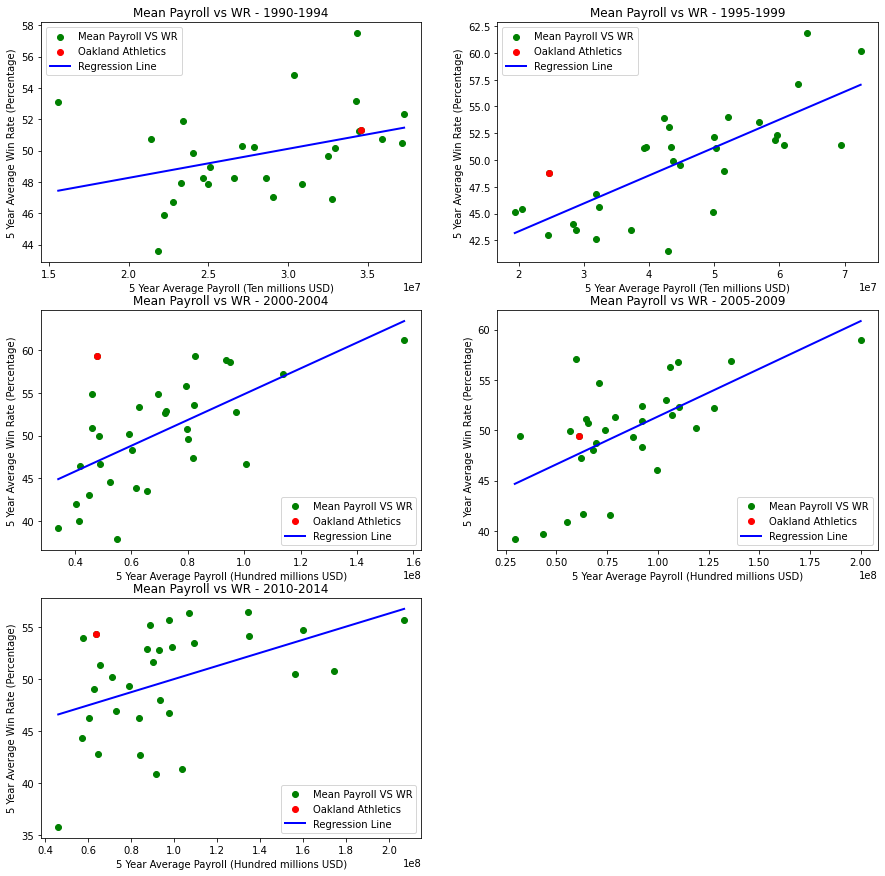

In [112]:
#creating and categorizing bins
group_names = ["1","2","3","4","5"]
team_salaries["bins"] = pandas.cut(x=team_salaries["Year"], bins = [1989, 1995, 2000, 2005, 2010, 2014],labels = group_names)

#setting up graph with 5 subplots
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)

# mwp = mean winning percentage, mp = mean payroll. The numbers correspond to which graph and therefore which spending year range it is in

#start off with mean payroll since we have similar experiences of getting this data for the previous graphs
mp1 = team_salaries[team_salaries["bins"] == "1"]
mp1 = mp1.groupby(by = ["Name"])["Salary Cap"].mean()
mp2 = team_salaries[team_salaries["bins"] == "2"]
mp2 = mp2.groupby(by = ["Name"])["Salary Cap"].mean()
mp3 = team_salaries[team_salaries["bins"] == "3"]
mp3 = mp3.groupby(by = ["Name"])["Salary Cap"].mean()
mp4 = team_salaries[team_salaries["bins"] == "4"]
mp4 = mp4.groupby(by = ["Name"])["Salary Cap"].mean()
mp5 = team_salaries[team_salaries["bins"] == "5"]
mp5 = mp5.groupby(by = ["Name"])["Salary Cap"].mean()
mp5
#do a similar thing but now with win percentage, this is where the already calculated win rate comes in very very very very very handy!
mwp1 = team_salaries[team_salaries["bins"] == "1"]
mwp1 = mwp1.groupby(by = ["Name"])["Win Rate"].mean()
mwp2 = team_salaries[team_salaries["bins"] == "2"]
mwp2 = mwp2.groupby(by = ["Name"])["Win Rate"].mean()
mwp3 = team_salaries[team_salaries["bins"] == "3"]
mwp3 = mwp3.groupby(by = ["Name"])["Win Rate"].mean()
mwp4 = team_salaries[team_salaries["bins"] == "4"]
mwp4 = mwp4.groupby(by = ["Name"])["Win Rate"].mean()
mwp5 = team_salaries[team_salaries["bins"] == "5"]
mwp5 = mwp5.groupby(by = ["Name"])["Win Rate"].mean()

#plot it
ax1.scatter(mp1, mwp1, color = "green", label = "Mean Payroll VS WR", marker = "o")
ax1.scatter(mp1["Oakland Athletics"], mwp1["Oakland Athletics"], color = "red", label = "Oakland Athletics", marker = "o")

ax2.scatter(mp2, mwp2, color = "green", label = "Mean Payroll VS WR", marker = "o")
ax2.scatter(mp2["Oakland Athletics"], mwp2["Oakland Athletics"], color = "red", label = "Oakland Athletics", marker = "o")

ax3.scatter(mp3, mwp3, color = "green", label = "Mean Payroll VS WR", marker = "o")
ax3.scatter(mp3["Oakland Athletics"], mwp3["Oakland Athletics"], color = "red", label = "Oakland Athletics", marker = "o")

ax4.scatter(mp4, mwp4, color = "green", label = "Mean Payroll VS WR", marker = "o")
ax4.scatter(mp4["Oakland Athletics"], mwp4["Oakland Athletics"], color = "red", label = "Oakland Athletics", marker = "o")

ax5.scatter(mp5, mwp5, color = "green", label = "Mean Payroll VS WR", marker = "o")
ax5.scatter(mp5["Oakland Athletics"], mwp5["Oakland Athletics"], color = "red", label = "Oakland Athletics", marker = "o")


#regression lines
b1, a1 = numpy.polyfit(mp1, mwp1, deg=1)
b2, a2 = numpy.polyfit(mp2, mwp2, deg=1)
b3, a3 = numpy.polyfit(mp3, mwp3, deg=1)
b4, a4 = numpy.polyfit(mp4, mwp4, deg=1)
b5, a5 = numpy.polyfit(mp5, mwp5, deg=1)

# Create evenly spread sequence of 100 numbers from min and max. Chose 100 since if we do the actual range (max - min), it crashes the program with 
# the amount of space required
xseq1 = numpy.linspace(mp1.min(), mp1.max(), num=100)
xseq2 = numpy.linspace(mp2.min(), mp2.max(), num=100)
xseq3 = numpy.linspace(mp3.min(), mp3.max(), num=100)
xseq4 = numpy.linspace(mp4.min(), mp4.max(), num=100)
xseq5 = numpy.linspace(mp5.min(), mp5.max(), num=100)

# Plot regression line
ax1.plot(xseq1, a1 + b1 * xseq1, color="blue", lw=2, label = "Regression Line");
ax2.plot(xseq2, a2 + b2 * xseq2, color="blue", lw=2, label = "Regression Line");
ax3.plot(xseq3, a3 + b3 * xseq3, color="blue", lw=2, label = "Regression Line");
ax4.plot(xseq4, a4 + b4 * xseq4, color="blue", lw=2, label = "Regression Line");
ax5.plot(xseq5, a5 + b5 * xseq5, color="blue", lw=2, label = "Regression Line");

#axis
ax1.set_xlabel("5 Year Average Payroll (Ten millions USD)")
ax2.set_xlabel("5 Year Average Payroll (Ten millions USD)")
ax3.set_xlabel("5 Year Average Payroll (Hundred millions USD)")
ax4.set_xlabel("5 Year Average Payroll (Hundred millions USD)")
ax5.set_xlabel("5 Year Average Payroll (Hundred millions USD)")

ax1.set_ylabel("5 Year Average Win Rate (Percentage)")
ax2.set_ylabel("5 Year Average Win Rate (Percentage)")
ax3.set_ylabel("5 Year Average Win Rate (Percentage)")
ax4.set_ylabel("5 Year Average Win Rate (Percentage)")
ax5.set_ylabel("5 Year Average Win Rate (Percentage)")

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()

ax1.set_title("Mean Payroll vs WR - 1990-1994")
ax2.set_title("Mean Payroll vs WR - 1995-1999")
ax3.set_title("Mean Payroll vs WR - 2000-2004")
ax4.set_title("Mean Payroll vs WR - 2005-2009")
ax5.set_title("Mean Payroll vs WR - 2010-2014")


So for this, I used bin to categorize the data into 5 categories, 1 being 1990-1995, and so on until 5 was 2010-2014. Now that the data was categorized, I used groupby statements very similar to earlier to obtain a series from the dataframe where I only had the teams salary cap average across that pay period or just the teams mean winning average per pay period. What I did to make my life A LOT easier was go back and add Win Rate as a data column when doing SQL operations. This saved a lot of time here. I then simply stored all that summarized data into arrays, and then plotted it in 5 separate graphs using subplots.

## Question 2
These graphs show that there exists a positive correlation between a team's payroll and a teams win rate. This correlation seems to exist across all time periods, but is weakest from 1990-1994 and strongest afterwards, and has remained relatively the same. However, there is high variation off the regression line, as some teams have a lot of differing win rates than the regression line would suggest. As we must note, this is simply correlation and causation cannot be inferred. 

It also continues our trend of seeing a lot more money being spent. The 5 year averages are in hundreds of millions now, up from the tens of millions, and still slowly still climbing.

As for trends specifically to the Oakland Athletics, it is pretty interesting and almost impressive. From 1990-1994, they averaged spending more money but did not see any truly impressive results in their win rate as compared to the regression line. However, in every single plot afterward, they have consistently outperformed the regression line. They consistently spend the **least** but still have positive win rate percentages and highly outperform the regression line consistently. It is of note that this trend began in the era of 2000-2004, the age of Moneyball, and it was in this era where they outperformed the regression line the most.

# Part 3: Data Transformations

## Problem 5

In [113]:
#begin by setting up the arrays and information needed to calculate the standardized payroll
yearlySalary = yearlySalary[5::]
yearlySalary = yearlySalary.tolist()

#obtaining stanrdard deviations

standard_deviations = team_salaries.groupby(by = ["Year"])["Salary Cap"].std()
standard_deviations = standard_deviations[5::]
standard_deviations = standard_deviations.tolist()

#adding it to our main dataframe
team_salaries["Standardized Payroll"] = 0.0

for i, row in team_salaries.iterrows():
    if row["Year"] >= 1990:
        year = row["Year"] - 1990
        team_salaries.at[i, "Standardized Payroll"] = (row["Salary Cap"] - yearlySalary[year]) / standard_deviations[year]

team_salaries.tail(10)

,Year,Name,Franchise ID,Team ID,W,G,Win Rate,Salary Cap,bins,Standardized Payroll
848,2014,Philadelphia Phillies,PHI,PHI,73,162,45.1,180944967.0,5,1.775404
849,2014,Pittsburgh Pirates,PIT,PIT,88,162,54.3,77178000.0,5,-0.494957
850,2014,San Diego Padres,SDP,SDN,77,162,47.5,75685700.0,5,-0.527607
851,2014,Seattle Mariners,SEA,SEA,87,162,53.7,92531100.0,5,-0.159040
852,2014,San Francisco Giants,SFG,SFN,88,162,54.3,20000000.0,5,-1.745978
853,2014,St. Louis Cardinals,STL,SLN,90,162,55.6,120693000.0,5,0.457126
854,2014,Tampa Bay Rays,TBD,TBA,77,162,47.5,72689100.0,5,-0.593171
855,2014,Texas Rangers,TEX,TEX,67,162,41.4,112255059.0,5,0.272509
856,2014,Toronto Blue Jays,TOR,TOR,83,162,51.2,109920100.0,5,0.221422
857,2014,Washington Nationals,WSN,WAS,96,162,59.3,131983680.0,5,0.704160


So this code simply set up 2 lists, one that had all the mean salaries by year which we calculated earlier (so avg_payroll in the formula) and the other which had the standard deviations per each year. Then we create the new column using the calculation for the standardized payroll.

## Problem 6

Text(0.5, 1.0, 'Standardized Payroll vs WR - 2010-2014')

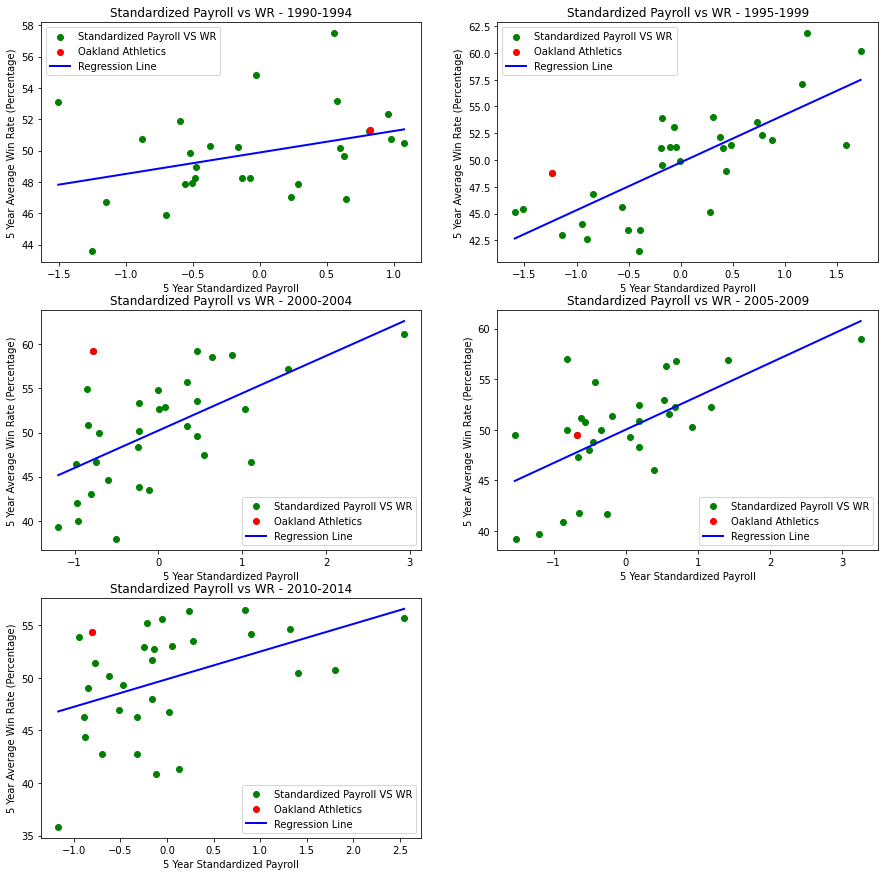

In [114]:
#setting up graph with 5 subplots
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)

# mwp = mean winning percentage, mp = mean payroll. The numbers correspond to which graph and therefore which spending year range it is in

#start off with mean payroll since we have similar experiences of getting this data for the previous graphs
mp1 = team_salaries[team_salaries["bins"] == "1"]
mp1 = mp1.groupby(by = ["Name"])["Standardized Payroll"].mean()
mp2 = team_salaries[team_salaries["bins"] == "2"]
mp2 = mp2.groupby(by = ["Name"])["Standardized Payroll"].mean()
mp3 = team_salaries[team_salaries["bins"] == "3"]
mp3 = mp3.groupby(by = ["Name"])["Standardized Payroll"].mean()
mp4 = team_salaries[team_salaries["bins"] == "4"]
mp4 = mp4.groupby(by = ["Name"])["Standardized Payroll"].mean()
mp5 = team_salaries[team_salaries["bins"] == "5"]
mp5 = mp5.groupby(by = ["Name"])["Standardized Payroll"].mean()
mp5
#do a similar thing but now with win percentage, this is where the already calculated win rate comes in very very very very very handy!
mwp1 = team_salaries[team_salaries["bins"] == "1"]
mwp1 = mwp1.groupby(by = ["Name"])["Win Rate"].mean()
mwp2 = team_salaries[team_salaries["bins"] == "2"]
mwp2 = mwp2.groupby(by = ["Name"])["Win Rate"].mean()
mwp3 = team_salaries[team_salaries["bins"] == "3"]
mwp3 = mwp3.groupby(by = ["Name"])["Win Rate"].mean()
mwp4 = team_salaries[team_salaries["bins"] == "4"]
mwp4 = mwp4.groupby(by = ["Name"])["Win Rate"].mean()
mwp5 = team_salaries[team_salaries["bins"] == "5"]
mwp5 = mwp5.groupby(by = ["Name"])["Win Rate"].mean()

#plot it
ax1.scatter(mp1, mwp1, color = "green", label = "Standardized Payroll VS WR", marker = "o")
ax1.scatter(mp1["Oakland Athletics"], mwp1["Oakland Athletics"], color = "red", label = "Oakland Athletics", marker = "o")

ax2.scatter(mp2, mwp2, color = "green", label = "Standardized Payroll VS WR", marker = "o")
ax2.scatter(mp2["Oakland Athletics"], mwp2["Oakland Athletics"], color = "red", label = "Oakland Athletics", marker = "o")

ax3.scatter(mp3, mwp3, color = "green", label = "Standardized Payroll VS WR", marker = "o")
ax3.scatter(mp3["Oakland Athletics"], mwp3["Oakland Athletics"], color = "red", label = "Oakland Athletics", marker = "o")

ax4.scatter(mp4, mwp4, color = "green", label = "Standardized Payroll VS WR", marker = "o")
ax4.scatter(mp4["Oakland Athletics"], mwp4["Oakland Athletics"], color = "red", label = "Oakland Athletics", marker = "o")

ax5.scatter(mp5, mwp5, color = "green", label = "Standardized Payroll VS WR", marker = "o")
ax5.scatter(mp5["Oakland Athletics"], mwp5["Oakland Athletics"], color = "red", label = "Oakland Athletics", marker = "o")


#regression lines
b1, a1 = numpy.polyfit(mp1, mwp1, deg=1)
b2, a2 = numpy.polyfit(mp2, mwp2, deg=1)
b3, a3 = numpy.polyfit(mp3, mwp3, deg=1)
b4, a4 = numpy.polyfit(mp4, mwp4, deg=1)
b5, a5 = numpy.polyfit(mp5, mwp5, deg=1)

# Create evenly spread sequence of 100 numbers from min and max. Chose 100 since if we do the actual range (max - min), 
#it crashes the program with the amount of space required
xseq1 = numpy.linspace(mp1.min(), mp1.max(), num=100)
xseq2 = numpy.linspace(mp2.min(), mp2.max(), num=100)
xseq3 = numpy.linspace(mp3.min(), mp3.max(), num=100)
xseq4 = numpy.linspace(mp4.min(), mp4.max(), num=100)
xseq5 = numpy.linspace(mp5.min(), mp5.max(), num=100)

# Plot regression line
ax1.plot(xseq1, a1 + b1 * xseq1, color="blue", lw=2, label = "Regression Line");
ax2.plot(xseq2, a2 + b2 * xseq2, color="blue", lw=2, label = "Regression Line");
ax3.plot(xseq3, a3 + b3 * xseq3, color="blue", lw=2, label = "Regression Line");
ax4.plot(xseq4, a4 + b4 * xseq4, color="blue", lw=2, label = "Regression Line");
ax5.plot(xseq5, a5 + b5 * xseq5, color="blue", lw=2, label = "Regression Line");

#axis
ax1.set_xlabel("5 Year Standardized Payroll")
ax2.set_xlabel("5 Year Standardized Payroll")
ax3.set_xlabel("5 Year Standardized Payroll")
ax4.set_xlabel("5 Year Standardized Payroll")
ax5.set_xlabel("5 Year Standardized Payroll")


ax1.set_ylabel("5 Year Average Win Rate (Percentage)")
ax2.set_ylabel("5 Year Average Win Rate (Percentage)")
ax3.set_ylabel("5 Year Average Win Rate (Percentage)")
ax4.set_ylabel("5 Year Average Win Rate (Percentage)")
ax5.set_ylabel("5 Year Average Win Rate (Percentage)")

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()

ax1.set_title("Standardized Payroll vs WR - 1990-1994")
ax2.set_title("Standardized Payroll vs WR - 1995-1999")
ax3.set_title("Standardized Payroll vs WR - 2000-2004")
ax4.set_title("Standardized Payroll vs WR - 2005-2009")
ax5.set_title("Standardized Payroll vs WR - 2010-2014")

For this problem we simply had to do the same thing we did earlier, but with a new x axis. It is a simple swap since we have the new x axis already all calculated out for us. Therefore it is nothing new but the take aways may change.

## Question 3

While the plots look very similar (the y values have not changed since it is still WR and the x values are using the same data points just with modified calculations), there does exist a difference. The first difference is that it is easier to compare between years as the x values have been standardized per year. This means that each point is already contrasted with the year it was a part of. Even with these changes, our correlation still appears as it did previously. Starting in 2000-2004, the Oakland Athletics went on a extremely hot streak in which they spent little compared to the payrolls of that year, but maintained a high win rate. This was an extreme difference against the regression line. Unfortunately, this streak fizzled down to normalcy in the years 2005-2009 but then increased again in 2010-2014. We do see that from 1990-1999, the Oakland Athletic's performed close to the regression line. However, it must be noted that this is still only correlation, and causation cannot be taken from this data, even with the new calculations. 

In general, these plots still demonstrate similar properties as before. Win rates seem to be positively correlated with payroll, whether it be standardized or not. It also demonstrates the high variation in the data, especially as time goes on. While the correlation exists that teams that spend more seemingly win more, there are extreme cases of this and cases where the opposite occurs. Therefore, in general, our new plots with our new X axis still maintains the information tooken away from Problem 4, but it is easier to compare by year, and since the X range is much smaller than before.

## Problem 7

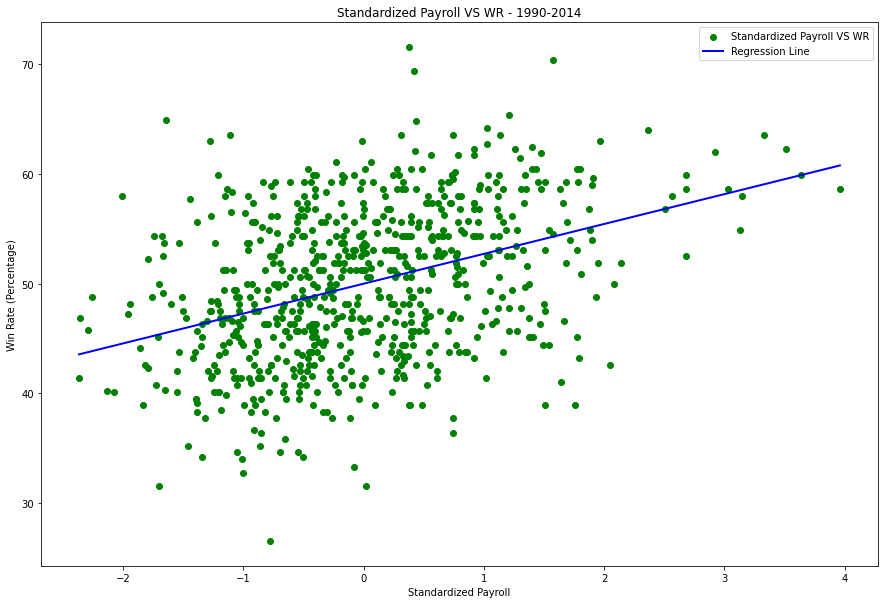

In [115]:
#We have all the data, just need to graph it. Here we start off by isolating the data in the correct time frame into x
x = team_salaries[team_salaries["Standardized Payroll"] != 0]

#plotting the data
plt.scatter(x["Standardized Payroll"], x["Win Rate"], color = "green")

#calculating regression
b1, a1 = numpy.polyfit(x["Standardized Payroll"], x["Win Rate"], deg=1)
xseq1 = numpy.linspace(x["Standardized Payroll"].min(), x["Standardized Payroll"].max(), num=100)
plt.plot(xseq1, a1 + b1 * xseq1, color="blue", lw=2, label = "Regression Line");


#This edits the graph axis
plt.legend(["Standardized Payroll VS WR", "Regression Line"])
plt.title("Standardized Payroll VS WR - 1990-2014")
plt.ylabel("Win Rate (Percentage)")
plt.xlabel("Standardized Payroll")
plt.show()

This problem was relatively straightforward. We did the same operations as before but we just stored it in a list to make things more convenient. Then we plotted it and created a linear regression for it.

## Problem 8
Now we have to create variables expected win percentage and efficiency. We can do this by modifying the columns of the main dataframe using the calculations we already have.

First we modify the dataframe to have the Expected Win Percentage for years 1990-2014.

In [116]:
team_salaries["Expected Win Percentage"] = 0.0

for i, row in team_salaries.iterrows():
    if row["Year"] >= 1990:
        team_salaries.at[i, "Expected Win Percentage"] = 50 + (2.5 * team_salaries.at[i, "Standardized Payroll"])
        
#see our work
team_salaries.tail(10)

,Year,Name,Franchise ID,Team ID,W,G,Win Rate,Salary Cap,bins,Standardized Payroll,Expected Win Percentage
848,2014,Philadelphia Phillies,PHI,PHI,73,162,45.1,180944967.0,5,1.775404,54.438511
849,2014,Pittsburgh Pirates,PIT,PIT,88,162,54.3,77178000.0,5,-0.494957,48.762609
850,2014,San Diego Padres,SDP,SDN,77,162,47.5,75685700.0,5,-0.527607,48.680982
851,2014,Seattle Mariners,SEA,SEA,87,162,53.7,92531100.0,5,-0.159040,49.602401
852,2014,San Francisco Giants,SFG,SFN,88,162,54.3,20000000.0,5,-1.745978,45.635055
853,2014,St. Louis Cardinals,STL,SLN,90,162,55.6,120693000.0,5,0.457126,51.142816
854,2014,Tampa Bay Rays,TBD,TBA,77,162,47.5,72689100.0,5,-0.593171,48.517072
855,2014,Texas Rangers,TEX,TEX,67,162,41.4,112255059.0,5,0.272509,50.681273
856,2014,Toronto Blue Jays,TOR,TOR,83,162,51.2,109920100.0,5,0.221422,50.553554
857,2014,Washington Nationals,WSN,WAS,96,162,59.3,131983680.0,5,0.704160,51.760400


Now we do add a new column to the data frame, this time efficiency. We can utilize the same method as before since we are doing calculations on data columns we already have!

In [117]:
team_salaries["Efficiency"] = 0.0

for i, row in team_salaries.iterrows():
    if row["Year"] >= 1990:
        team_salaries.at[i, "Efficiency"] = team_salaries.at[i,"Win Rate"] - team_salaries.at[i, "Expected Win Percentage"]
        
#see our work
team_salaries.tail(10)

,Year,Name,Franchise ID,Team ID,W,G,Win Rate,Salary Cap,bins,Standardized Payroll,Expected Win Percentage,Efficiency
848,2014,Philadelphia Phillies,PHI,PHI,73,162,45.1,180944967.0,5,1.775404,54.438511,-9.338511
849,2014,Pittsburgh Pirates,PIT,PIT,88,162,54.3,77178000.0,5,-0.494957,48.762609,5.537391
850,2014,San Diego Padres,SDP,SDN,77,162,47.5,75685700.0,5,-0.527607,48.680982,-1.180982
851,2014,Seattle Mariners,SEA,SEA,87,162,53.7,92531100.0,5,-0.159040,49.602401,4.097599
852,2014,San Francisco Giants,SFG,SFN,88,162,54.3,20000000.0,5,-1.745978,45.635055,8.664945
853,2014,St. Louis Cardinals,STL,SLN,90,162,55.6,120693000.0,5,0.457126,51.142816,4.457184
854,2014,Tampa Bay Rays,TBD,TBA,77,162,47.5,72689100.0,5,-0.593171,48.517072,-1.017072
855,2014,Texas Rangers,TEX,TEX,67,162,41.4,112255059.0,5,0.272509,50.681273,-9.281273
856,2014,Toronto Blue Jays,TOR,TOR,83,162,51.2,109920100.0,5,0.221422,50.553554,0.646446
857,2014,Washington Nationals,WSN,WAS,96,162,59.3,131983680.0,5,0.704160,51.760400,7.539600


With that done, we can now plot a line graph using the data above. To do this, we will use a list and a dictionary to iterate through and plot our points while color coding the teams.

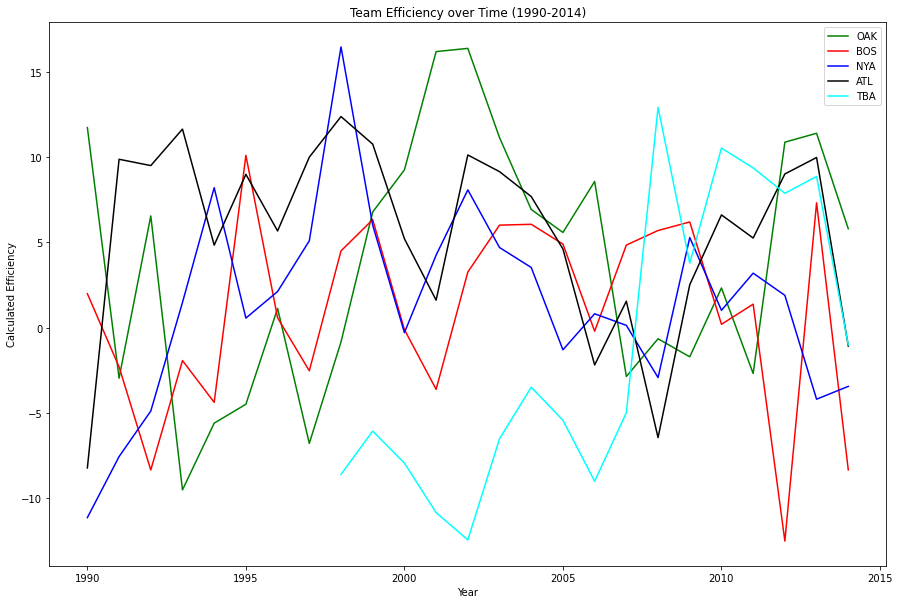

In [118]:
#Isolate by team
teams = ["OAK", "BOS", "NYA", "ATL", "TBA"]
#dictionary to store colors for later on
colors = {"OAK":"green", "BOS":"red", "NYA":"blue", "ATL":"black", "TBA":"cyan"}

#iterate through teams to plot and label
for team in teams:
    t_df = team_salaries[(team_salaries["Team ID"] == team) & (team_salaries["Year"] >= 1990)]
    plt.plot(t_df["Year"], t_df["Efficiency"], color = colors[team], label = team)

#plot labeling
plt.legend()
plt.title("Team Efficiency over Time (1990-2014)")
plt.ylabel("Calculated Efficiency")
plt.xlabel("Year")
plt.show()

## Question 4
The other graphs in question 2 and 3 were operating based off money spent and win rate comparisons. This graph instead analyzes a teams calculated efficiency over time. A high efficiency is a good thing, it is calculated based off win rate and money spent while accounting for each year's average and standard deviation in spending. In essence, it measures how much better or worse a team performs when accounting for the amount of money spent by that team. Compared to graph 2 and 3, we still take away similar things. Oakland got their money's worth from their players, and exceeded their expectations when basing off of their payroll.

With that being said, it is clear that from a period between 2000 and 2005, the Oakland Athletics had some of the most efficient seasons seen in this time period (1990-2015) and within this grouping of teams (Oakland Athletics, Boston Red Sox, New York Yankees, Atlanta Braves, and Tampa Bay Rays). Aside from one stellar efficiency outlier season from the New York Yankees in 1998, the Oakland Athletic's moneyball streak was the highest efficiency calculated in this time period and within this grouping of teams. They truly exceeded expectations and exceeded their expected performance when based off of payroll. 

Therefore, during this moneyball era, Oakland truly hit their mark and found value with all their players. While this graph just compares 2 variables and doesn't imply causation, it is apparent that Oakland truly got their moneys worth from their players. Unfortunately, whether it be from other teams catching on or simply their own misfortune, Oakland regressed back to the level of other teams in regards to efficiency after the moneyball era, but they do seem to be performing well towards the end of the recorded data.